## Отчетность по банковским резервам

Сегодня 1 августа 2022 года. Рассчитайте суммарный объем резервов из расчета на 1 августа 2022 года.

Напишите функцию, которая будет на вход брать отчетную дату (например, 1 августа 2022 года) и датафрейм по аналогии с файлом Client_Data_01082022 и будет рассчитывать суммарный объем банковских резервов на отчетную дату.

Предположим худший возможный сценарий: начиная с 1 августа больше никто не оплатил ни копейки по своим кредитам в связи с макроэкономической ситуацией. 

Постройте график суммарных резервов для набора отчетных дат от 1 до 30 августа (включительно) и оцените абсолютный и процентный прирост резервов за месяц.

Постройте в питоне визуализации, которые помогут отследить размер резервов (например, в разрезе продукта или размера выданного кредита).

In [3]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from datetime import date, timedelta

import warnings
warnings.filterwarnings("ignore")

In [4]:
#Импорт файлов
CD    = pd.read_csv('Client_Data_01082022.csv', sep=';')
bc    = pd.read_csv('bucket_coeff.csv', sep=';')
ct    = pd.read_csv('credit_type.csv', sep=';')

In [5]:
CD.head()

,id_credit,last_inst_payment,amt_instalment,id_credit_type
0,237789,04.05.2022,25669,888
1,238348,18.02.2022,5271,246
2,238164,06.05.2022,33732,246
3,237613,14.03.2022,6108,246
4,237745,05.02.2022,4917,888


In [6]:
bc.head()

,id_bucket,range_bucket,coeff,valid_to
0,1,0-15,"0,05",01.01.3000
1,2,16-30,"0,25",01.01.3000
2,3,31-60,"0,33",01.01.3000
3,4,61-90,"0,6",01.01.3000
4,5,91-120,"0,75",01.01.3000


In [7]:
ct.info

<bound method DataFrame.info of     id_credit_type     name_credit_type
0              117          POS-special
1              118          POS-classic
2              119         POS-restruct
3              245        RC-experiment
4              246                   RC
5              247           RC-special
6              248          RC-restruct
7              249        RC-new format
8              888      Cash-in classic
9              889     Cash-in restruct
10            1024   Autocredit-special
11            1025  Autocredit-restruct
12            1026      Autocredit-bail
13            1027    Autocredit-select
14            1028   Autocredit-classic
15            1029       Autocredit-new>

In [8]:
bc['valid_to'].unique()

array(['01.01.3000', '01.07.2022'], dtype=object)

In [9]:
today = pd.to_datetime('2022-08-01')

#Выделяем только актуальные коэффициенты резервирования (те, что пока без даты окончания)
bc_act = bc[bc['valid_to']=='01.01.3000']
#Приводим даты в нужный формат
CD['last_inst_payment'] = pd.to_datetime(CD['last_inst_payment'], format='%d.%m.%Y')
#И объединяем таблицу платежей с таблицей типов кредита
CD = CD.merge(ct, on = 'id_credit_type')

In [10]:
bc_act.head(5)

,id_bucket,range_bucket,coeff,valid_to
0,1,0-15,"0,05",01.01.3000
1,2,16-30,"0,25",01.01.3000
2,3,31-60,"0,33",01.01.3000
3,4,61-90,"0,6",01.01.3000
4,5,91-120,"0,75",01.01.3000


In [11]:
#Переводим коэффициент в нужный формат
bc_act['coeff'] = bc_act['coeff'].str.replace(',', '.').astype(float)

In [12]:
#Пишем функцию, которая будет на вход брать отчетную дату и датафрейм 
#и будет рассчитывать суммарный объем банковских резервов на отчетную дату.
def calc_reserves(df, date_calc):
    #Создаем столбец с колличеством дней просрочки (Прибавляем месяц к последней дате платежа что-бы исключить кредиты без просрочки)
    df['dpd'] = (date_calc - (df['last_inst_payment'] + DateOffset(months=1)))/np.timedelta64(1, 'D')
    df = df[(df['dpd'] > 0)]
    #Создаем столбец с id коэффициента для полученных дней 
    df['id_bucket'] = np.where(df['dpd'] <= 15, 1,
                  np.where(df['dpd'] <= 30, 2,
                  np.where(df['dpd'] <= 60, 3,
                  np.where(df['dpd'] <= 90, 4,
                  np.where(df['dpd'] <= 120, 5,
                  np.where(df['dpd'] <= 150, 6,
                  np.where(df['dpd'] <= 180, 7, 8
                          )))))))
    #Добавляем таблицу с коэффициентами 
    df = df.merge(bc_act, on = 'id_bucket', how='left')
    #Создаем столбец с данными по резервам
    df['amt_res'] = df['amt_instalment'] * df['coeff']
    #Группируем по дням просрочки и типу кредита
    df_gr = df.groupby(['range_bucket','name_credit_type']).agg({'amt_res':'sum',
                                                                 'id_credit':'count',
                                                                 'amt_instalment':'sum'}).reset_index()
    #Добавляем столбец обобщаюший подтипы кредита  
    df_gr['credit_type_name_agg'] = np.where(df_gr['name_credit_type'].str.contains('POS'),'POS',
                  np.where(df_gr['name_credit_type'].str.contains('RC'),'RC',
                  np.where(df_gr['name_credit_type'].str.contains('Autocredit'),'Autocredit','Cash-in'
                          )))
    
    return df_gr

In [13]:
CD['today'] = today

In [14]:
CD['days_delay'] = CD['today'] - CD['last_inst_payment']

In [15]:
CD.head()

,id_credit,last_inst_payment,amt_instalment,id_credit_type,name_credit_type,today,days_delay
0,237789,2022-05-04,25669,888,Cash-in classic,2022-08-01,89 days
1,238348,2022-02-18,5271,246,RC,2022-08-01,164 days
2,238164,2022-05-06,33732,246,RC,2022-08-01,87 days
3,237613,2022-03-14,6108,246,RC,2022-08-01,140 days
4,237745,2022-02-05,4917,888,Cash-in classic,2022-08-01,177 days


In [16]:
df_gr_loc = calc_reserves(CD, today)

In [17]:
df_gr_loc.head(15)

,range_bucket,name_credit_type,amt_res,id_credit,amt_instalment,credit_type_name_agg
0,0-15,Autocredit-bail,699.60,2,13992,Autocredit
1,0-15,Autocredit-classic,4443.25,6,88865,Autocredit
2,0-15,Autocredit-restruct,252.05,1,5041,Autocredit
3,0-15,Autocredit-special,386.70,1,7734,Autocredit
4,0-15,Cash-in classic,1426.10,2,28522,Cash-in
5,0-15,Cash-in restruct,3430.50,3,68610,Cash-in
6,0-15,POS-classic,17712.15,17,354243,POS
7,0-15,POS-restruct,8382.45,8,167649,POS
8,0-15,POS-special,3415.65,3,68313,POS
9,0-15,RC,10830.40,13,216608,RC


In [18]:
#Создаем таблицу суммарных резервов для дат с 1 по 30 августа
date_calc1 = pd.to_datetime('2022-08-01')
date_calc2 = pd.to_datetime('2022-08-30')

In [19]:
df_gr = pd.DataFrame()
#Добавлям в пустой фрейм данные для каждой отчетной даты
for dd in pd.date_range(start=date_calc1, end=date_calc2):
    df_gr_loc = calc_reserves(CD, dd)
    df_gr_loc['date_calc'] = dd
    df_gr = pd.concat([df_gr, df_gr_loc])

In [20]:
#Группируем суммы резервов по отчетной дате
df_gr_fin = df_gr.groupby('date_calc').sum()['amt_res'].reset_index()
#А так же по отчетной дате и типу кредита
df_gr_fin_pr = df_gr.groupby(['date_calc','credit_type_name_agg']).sum()['amt_res'].reset_index()

In [21]:
df_gr_fin.head(10)

,date_calc,amt_res
0,2022-08-01,12887441.87
1,2022-08-02,13041895.64
2,2022-08-03,13126664.61
3,2022-08-04,13253964.95
4,2022-08-05,13421574.99
5,2022-08-06,13542938.78
6,2022-08-07,13657186.64
7,2022-08-08,13781057.84
8,2022-08-09,13906173.55
9,2022-08-10,14060616.12


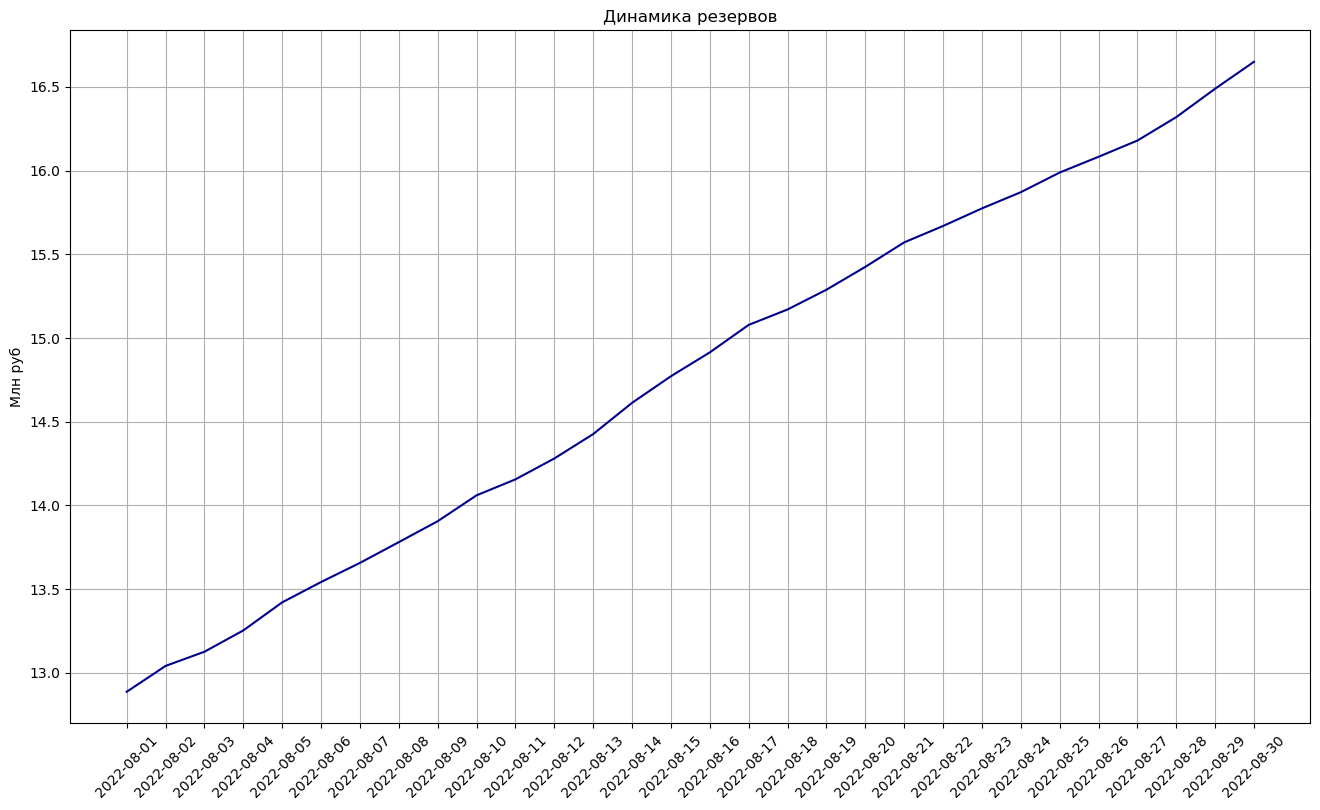

In [22]:
plt.figure(figsize=(16, 9))
plt.plot(df_gr_fin['date_calc'], df_gr_fin['amt_res'] * 1e-6, color='darkblue')
plt.xticks(df_gr_fin['date_calc'], rotation = 45)
plt.ylabel('Млн руб')
plt.title('Динамика резервов')
plt.grid()
plt.show()

In [23]:
#Посмотрим на данные в разрезе типа кредита
df_increase = df_gr_fin_pr.set_index(['credit_type_name_agg', 'date_calc']).unstack(level=-1)
df_increase = df_increase.loc[:, [('amt_res', date_calc1), ('amt_res', date_calc2)]]
df_increase.columns = [date_calc1, date_calc2]
#И подсчитаем абсолютный и процентный прирост резервов за месяц
df_increase['increase_%'] = (df_increase[date_calc2]-df_increase[date_calc1])/df_increase[date_calc1]
df_increase['increase_rub'] = df_increase[date_calc2]-df_increase[date_calc1]

In [24]:
df_increase.sort_values(by='increase_rub')\
           .style.format({'increase_%': '{:,.2%}'})

,2022-08-01 00:00:00,2022-08-30 00:00:00,increase_%,increase_rub
credit_type_name_agg,,,,
Cash-in,1084839.250000,1431752.600000,31.98%,346913.350000
Autocredit,3046988.790000,3923458.760000,28.77%,876469.970000
RC,4396949.040000,5650711.130000,28.51%,1253762.090000
POS,4358664.790000,5643970.640000,29.49%,1285305.850000


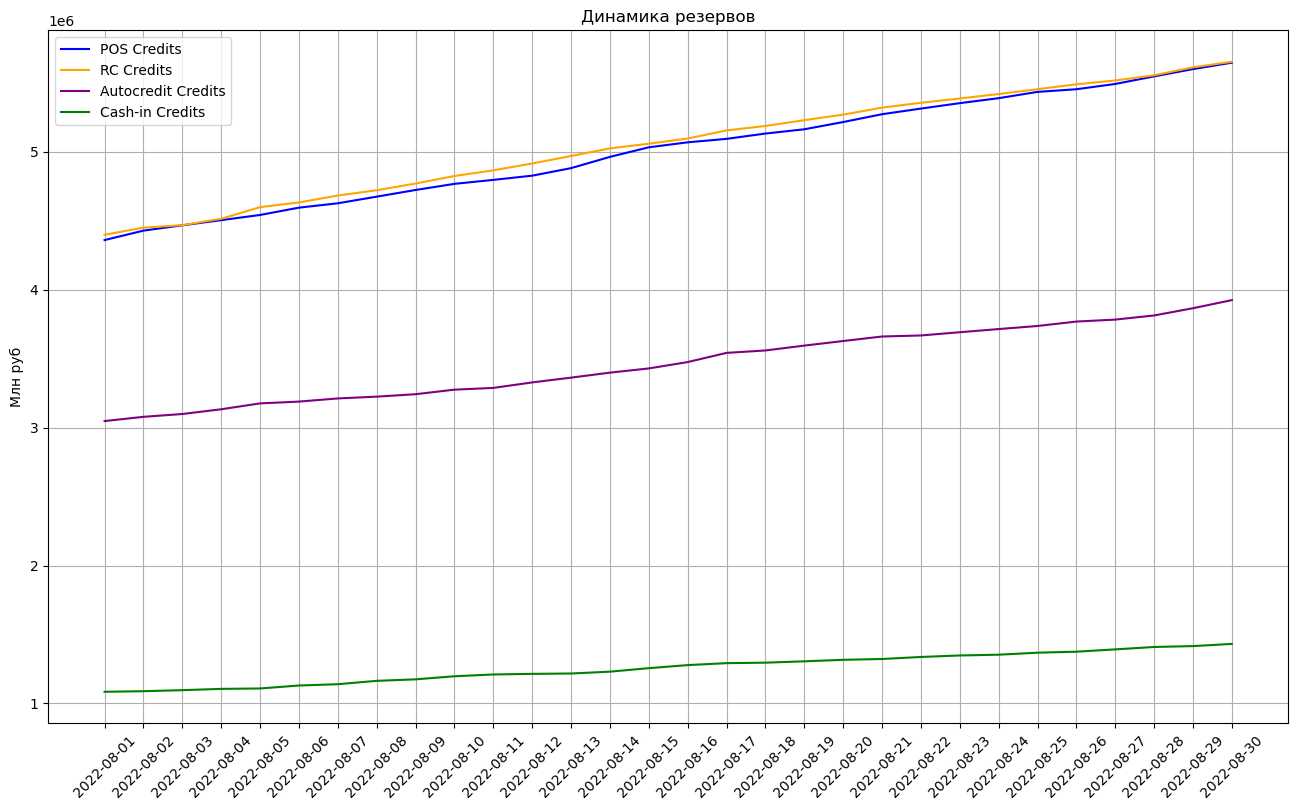

In [25]:
plt.figure(figsize=(16,9))

plt.plot(   df_gr_fin_pr[df_gr_fin_pr['credit_type_name_agg']=='POS']['date_calc']
          , df_gr_fin_pr[df_gr_fin_pr['credit_type_name_agg']=='POS']['amt_res'], label='POS Credits', color = 'blue')
plt.plot(   df_gr_fin_pr[df_gr_fin_pr['credit_type_name_agg']=='RC']['date_calc']
          , df_gr_fin_pr[df_gr_fin_pr['credit_type_name_agg']=='RC']['amt_res'], label='RC Credits', color = 'orange')
plt.plot(   df_gr_fin_pr[df_gr_fin_pr['credit_type_name_agg']=='Autocredit']['date_calc']
          , df_gr_fin_pr[df_gr_fin_pr['credit_type_name_agg']=='Autocredit']['amt_res'], label='Autocredit Credits', color = 'purple')
plt.plot(   df_gr_fin_pr[df_gr_fin_pr['credit_type_name_agg']=='Cash-in']['date_calc']
          , df_gr_fin_pr[df_gr_fin_pr['credit_type_name_agg']=='Cash-in']['amt_res'], label='Cash-in Credits', color = 'green')

plt.xticks(df_gr_fin_pr[df_gr_fin_pr['credit_type_name_agg']=='POS']['date_calc'], rotation = 45)
plt.title('Динамика резервов')
plt.ylabel('Млн руб')
plt.legend(loc='upper left')
plt.grid()
plt.show()